In [1]:
data_name = 'monster'
# data_name = 'rabbit'
# data_name = 'bear'
# data_name = 'dance'

In [2]:
# @title Import libraries, define the necessary auxiliary functions (mesh normalisation, rendering, etc.)

import numpy as np
from tqdm import tqdm
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    Textures,
    look_at_view_transform,
    FoVOrthographicCameras,
    Materials,
    RasterizationSettings,
    BlendParams,
    MeshRenderer,
    MeshRasterizer,
    AmbientLights,
    HardPhongShader,
)
from scipy.spatial.transform import Rotation as R

# Constants for magic numbers
DEVICE = 'cuda'
DEFAULT_IMAGE_SIZE = 512
DEFAULT_SCALE_VAL = 1.0
DEFAULT_RANDOM_SEED = 13


def rotate_mesh90(mesh):

  rotmat = torch.Tensor(R.from_rotvec(np.pi/2 * np.array([1, 0, 0])).as_matrix()).to(DEVICE)
  rotated_verts = mesh.verts_packed() @ rotmat

  return Meshes(rotated_verts.unsqueeze(0), mesh.faces_packed().unsqueeze(0), textures=mesh.textures)

def normals_to_rgb(normals: torch.Tensor) -> torch.Tensor:
    """
    Convert mesh normals to RGB color representation.

    Args:
        normals (torch.Tensor): Mesh normals.

    Returns:
        torch.Tensor: RGB colors based on the normals.
    """
    return torch.abs(normals * 0.5 + 0.5)

def get_normals_as_textures(mesh: Meshes) -> Meshes:
    """
    Create textures from mesh normals.

    Args:
        mesh (Meshes): Input mesh.

    Returns:
        Meshes: New mesh with normals as textures.
    """
    normals = mesh.verts_normals_packed()
    textures = Textures(verts_rgb=normals_to_rgb(normals).unsqueeze(0))
    return Meshes(mesh.verts_packed().unsqueeze(0), mesh.faces_packed().unsqueeze(0), textures)

def create_mesh_renderer(cameras, image_size=DEFAULT_IMAGE_SIZE, device='cuda'):
    """
    Create a mesh renderer.

    Args:
        cameras (FoVOrthographicCameras): Camera setup.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        device (str, optional): Device for computation. Defaults to 'cuda'.

    Returns:
        MeshRenderer: Mesh renderer.
    """
    materials = Materials(
        device=device,
        specular_color=[[0.0, 0.0, 0.0]],
        shininess=0.0
    )

    raster_settings = RasterizationSettings(
        image_size=image_size,
        blur_radius=0.0,
        faces_per_pixel=1,
        bin_size=None,
        cull_backfaces=True
    )

    blend_params = BlendParams(background_color=(0, 0, 0))

    lights = AmbientLights(ambient_color=(1, 1, 1), device=device)

    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),

        shader=HardPhongShader(device=device,
                               cameras=cameras,
                               blend_params=blend_params,
                               lights=lights,
                               materials=materials)
    )

    return renderer

def render_mesh(mesh, dist=1, elev=0, azim=0,
                image_size=DEFAULT_IMAGE_SIZE, radius=0.01, scale_val=1.0,
                device=DEVICE):
    """
    Render a mesh.

    Args:
        mesh (Meshes): Input mesh.
        dist (float, optional): Distance from the camera. Defaults to 1.
        elev (float, optional): Elevation angle. Defaults to 0.
        azim (float, optional): Azimuth angle. Defaults to 0.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        radius (float, optional): Radius. Defaults to 0.01.
        scale_val (float, optional): Scaling value. Defaults to 1.0.
        device (str, optional): Device to use for rendering. Defaults to DEVICE.

    Returns:
        torch.Tensor: Rendered image.
    """
    R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
    cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

    renderer = create_mesh_renderer(cam, image_size=image_size)

    img = renderer(mesh, cameras=cam)[0]

    return img


In [3]:
# Load GT mesh

SOURCE_MESH_PATH = '/home/bronyale/code/DPF/data/' + data_name + '/source.obj'
TARGET_MESH_PATH = '/home/bronyale/code/DPF/data/' + data_name + '/target.obj'

source_mesh = load_objs_as_meshes([SOURCE_MESH_PATH]).to(DEVICE)
source_mesh = get_normals_as_textures(source_mesh).to(DEVICE)

target_mesh = load_objs_as_meshes([TARGET_MESH_PATH]).to(DEVICE)
target_mesh = get_normals_as_textures(target_mesh).to(DEVICE)

/home/bronyale/anaconda3/envs/DPF/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/bronyale/code/DPF/data/monster/0.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/home/bronyale/anaconda3/envs/DPF/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/bronyale/code/DPF/data/monster/1.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


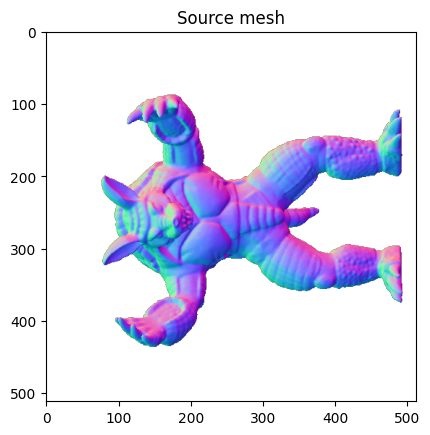

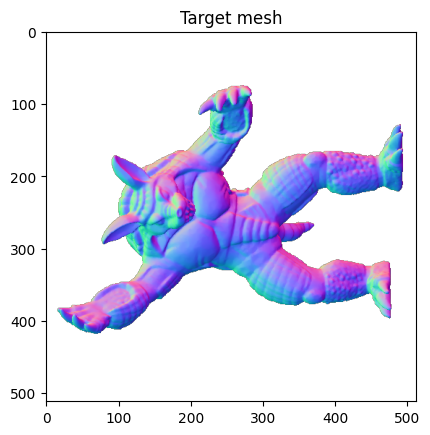

In [4]:
import matplotlib.pyplot as plt

source_mesh_render = render_mesh(rotate_mesh90(source_mesh), elev=90, azim=90).detach().cpu().numpy()
target_mesh_render = render_mesh(rotate_mesh90(target_mesh), elev=90, azim=90).detach().cpu().numpy()

# visualised source and target meshes
plt.figure()
plt.title("Source mesh")
plt.imshow(source_mesh_render)

plt.figure()
plt.title("Target mesh")
plt.imshow(target_mesh_render)

In [5]:
# @title Define SIREN deformation model
from torch import nn
import numpy as np

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords#.requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output #, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [6]:
# @title Define deformation learning function and AIAP loss
from tqdm import tqdm
import torch
from pytorch3d.ops.knn import knn_points
from pytorch3d.loss.chamfer import chamfer_distance
import torch
from torch.nn.functional import l1_loss

def aiap_loss(x_canonical, x_deformed, n_neighbors=5):
    """
    Computes the as-isometric-as-possible loss between two sets of points, which measures the discrepancy
    between their pairwise distances.

    Parameters
    ----------
    x_canonical : array-like, shape (n_points, n_dims)
        The canonical (reference) point set, where `n_points` is the number of points
        and `n_dims` is the number of dimensions.
    x_deformed : array-like, shape (n_points, n_dims)
        The deformed (transformed) point set, which should have the same shape as `x_canonical`.
    n_neighbors : int, optional
        The number of nearest neighbors to use for computing pairwise distances.
        Default is 5.

    Returns
    -------
    loss : float
        The AIAP loss between `x_canonical` and `x_deformed`, computed as the L1 norm
        of the difference between their pairwise distances. The loss is a scalar value.
    Raises
    ------
    ValueError
        If `x_canonical` and `x_deformed` have different shapes.
    """

    if x_canonical.shape != x_deformed.shape:
        raise ValueError("Input point sets must have the same shape.")

    _, nn_ix, _ = knn_points(x_canonical.unsqueeze(0),
                             x_canonical.unsqueeze(0),
                             K=n_neighbors,
                             return_sorted=True)

    dists_canonical = torch.cdist(x_canonical[nn_ix], x_canonical[nn_ix])
    dists_deformed = torch.cdist(x_deformed[nn_ix], x_deformed[nn_ix])

    loss = l1_loss(dists_canonical, dists_deformed)

    return loss


# deformation learning
def deform_cloud(model, xsrc, xtrg=None, vsrc=None, vtrg=None,
                 use_aiap=True, use_aiap_inter=True,
                 use_chamfer=True, use_guidance=True,
                 n_chamfer_samples=10**4, n_steps=20000, init_lr=1.0e-4,
                 aiap_weight=1.0e4, aiap_inter_max=1.0,
                 guided_weight=1.0e4, chamfer_weight=1.0e4,
                 iso_n_neighbors=5, eval_every_nth_step=100, device=DEVICE):
  """
  Deform a point cloud using a neural network model.

  Parameters
  ----------
  model : torch.nn.Module
      The neural network model to use for deformation.
  xsrc : numpy.ndarray
      The source point cloud to deform.
  xtrg : numpy.ndarray, optional
      The target point cloud to match (used in chamfer distance loss).
  vsrc : numpy.ndarray, optional
      The source keypoints to use as guidance for deformation.
  vtrg : numpy.ndarray, optional
      The target keypoints to match (used in guided loss).
  use_aiap : bool, optional
      Whether to use AIAP loss (default is True).
  use_aiap_inter : bool, optional
      Whether to use AIAP loss between halfway frames (default is True).
  use_chamfer : bool, optional
      Whether to use chamfer distance loss (default is True).
  use_guidance : bool, optional
      Whether to use guided loss (default is True).
  n_chamfer_samples : int, optional
      The number of points to sample for chamfer distance loss (default is 10**4).
  n_steps : int, optional
      The number of optimization steps (default is 20000).
  init_lr : float, optional
      The initial learning rate for the optimizer (default is 1.0e-4).
  aiap_weight : float, optional
      The weight for AIAP loss (default is 1.0e4).
  aiap_inter_max : float, optional
      The interval for AIAP loss between frames (default is 1.0). Check Section 3.2 for details
  guided_weight : float, optional
      The weight for guided loss (default is 1.0e4).
  chamfer_weight : float, optional
      The weight for chamfer distance loss (default is 1.0e4).
  iso_n_neighbors : int, optional
      The number of neighbors to use for isometric loss (default is 5).
  eval_every_nth_step : int, optional
      The number of steps between evaluations (default is 100).
  device: str, optional
      Device to use for rendering. Defaults to DEVICE.

  """

  model = model.train()
  l1_loss = torch.nn.L1Loss()
  optm = torch.optim.Adam(model.parameters(), lr=init_lr)
  schedm = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, verbose=True, patience=1)

  if use_chamfer and xtrg is None:
    print("no target cloud provided, ignoring...")
    use_chamfer = False

  if use_guidance and vtrg is None:
    print("no keypoints provided, ignoring...")
    use_guidance = False

  guided_loss_total = 0
  chamfer_loss_total = 0
  aiap_loss_total = 0
  total_loss = 0
  n_r = 0

  for i in range(0, n_steps):

    if use_aiap or use_chamfer or use_aiap_inter:
      xbatch_src = torch.Tensor(xsrc[np.random.choice(len(xsrc), n_chamfer_samples, replace=False)]).to(device)
      xbatch_deformed = xbatch_src + model(xbatch_src)

    if use_aiap_inter:
      # additionally enforce isometry between frames
      t = aiap_inter_max * np.random.uniform()
      xbatch_deformed_halfway = xbatch_src + aiap_inter_max*model(xbatch_src)

    loss = 0

    if use_aiap:
      iso_loss = aiap_weight*aiap_loss(xbatch_src, xbatch_deformed, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      aiap_loss_total += float(iso_loss)

    if use_aiap_inter:
      iso_loss += aiap_weight*aiap_loss(xbatch_src, xbatch_deformed_halfway, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      aiap_loss_total += float(iso_loss)

    if use_guidance:
      vsrc_deformed = vsrc + model(vsrc)
      guidance_loss = guided_weight*l1_loss(vsrc_deformed, vtrg)
      loss += guidance_loss
      guided_loss_total += float(guidance_loss)

    if use_chamfer:
      xbatch_trg = torch.Tensor(xtrg[np.random.choice(len(xtrg), n_chamfer_samples, replace=False)]).to(device)
      chamfer_loss = chamfer_weight*chamfer_distance(xbatch_deformed.unsqueeze(0),
                                                     xbatch_trg.unsqueeze(0))[0]
      loss += chamfer_loss
      chamfer_loss_total += float(chamfer_loss)

    total_loss += float(loss)
    n_r += 1

    optm.zero_grad()
    loss.backward()
    optm.step()

    if i % eval_every_nth_step == 0:

      guided_loss_total /= n_r
      aiap_loss_total /= n_r
      chamfer_loss_total /= n_r
      total_loss /= n_r

      schedm.step(float(total_loss))

      print("%05d total loss: %03f, guidl: %03f, chaml. :%03f, AIAP: %03f"
            % (i, total_loss, guided_loss_total, chamfer_loss_total, aiap_loss_total))

      guided_loss_total = 0
      chamfer_loss_total = 0
      aiap_loss_total = 0
      total_loss = 0
      n_r = 0

  guided_loss_total /= n_r
  aiap_loss_total /= n_r
  chamfer_loss_total /= n_r
  total_loss /= n_r

  print("%05d total loss: %03f, guidl: %03f, chaml. :%03f, AIAP: %03f"
            % (i, total_loss, guided_loss_total, chamfer_loss_total, aiap_loss_total))

  return

def deform_mesh(mesh, model):

  vsrc = source_mesh.verts_packed()
  vpred = vsrc + model(vsrc).detach().clone()
  mesh_pred = Meshes(vpred.unsqueeze(0), source_mesh.faces_packed().unsqueeze(0))

  return mesh_pred

In [7]:
from pytorch3d.ops import sample_points_from_meshes

NUM_POINTS = 10**6

# sample points used for learning deformation network
xsrc = sample_points_from_meshes(source_mesh.to(DEVICE), num_samples=NUM_POINTS)[0]
xtrg = sample_points_from_meshes(target_mesh.to(DEVICE), num_samples=NUM_POINTS)[0]


In [8]:
# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# AIAP weight is an important hyperparameter which helps control
# the isometry of the deformation: the higher the AIAP_WEIGHT,
# the more isometric (constrained) is the predicted deformation
AIAP_WEIGHT = 1.0e2

# start training
deform_cloud(model,
             xsrc=xsrc, xtrg=xtrg,
             init_lr=1.0e-4,
             n_steps=2000,
             use_chamfer=True,
             use_guidance=False,
             use_aiap=True,
             aiap_weight=AIAP_WEIGHT,
             device=DEVICE)

/home/bronyale/anaconda3/envs/DPF/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


00000 total loss: 199.438980, guidl: 0.000000, chaml. :198.690964, AIAP: 0.748010
00100 total loss: 9.135081, guidl: 0.000000, chaml. :8.329822, AIAP: 0.805259
00200 total loss: 3.329757, guidl: 0.000000, chaml. :2.921801, AIAP: 0.407956
00300 total loss: 3.157500, guidl: 0.000000, chaml. :2.859165, AIAP: 0.298336
00400 total loss: 3.081857, guidl: 0.000000, chaml. :2.835456, AIAP: 0.246401
00500 total loss: 3.037904, guidl: 0.000000, chaml. :2.825734, AIAP: 0.212170
00600 total loss: 2.989486, guidl: 0.000000, chaml. :2.807370, AIAP: 0.182116
00700 total loss: 2.923668, guidl: 0.000000, chaml. :2.768876, AIAP: 0.154792
00800 total loss: 2.923972, guidl: 0.000000, chaml. :2.777111, AIAP: 0.146861
00900 total loss: 2.920849, guidl: 0.000000, chaml. :2.778736, AIAP: 0.142113
01000 total loss: 2.903619, guidl: 0.000000, chaml. :2.766195, AIAP: 0.137424
01100 total loss: 2.901777, guidl: 0.000000, chaml. :2.770975, AIAP: 0.130802
01200 total loss: 2.888845, guidl: 0.000000, chaml. :2.75965

In [12]:
# Now, let's predict new mesh vertex locations with our learned deformation
from pytorch3d.io import IO
import os

model.eval()

vsrc = source_mesh.verts_packed()
vpred = vsrc + model(vsrc).detach().clone()

mesh_pred = deform_mesh(source_mesh, model)
mesh_pred = get_normals_as_textures(mesh_pred)

save_dir = os.path.join('./result', data_name)
os.makedirs(save_dir, exist_ok=True)
IO().save_mesh(mesh_pred, './result/' + data_name + '/source_deformed_aiap.obj')

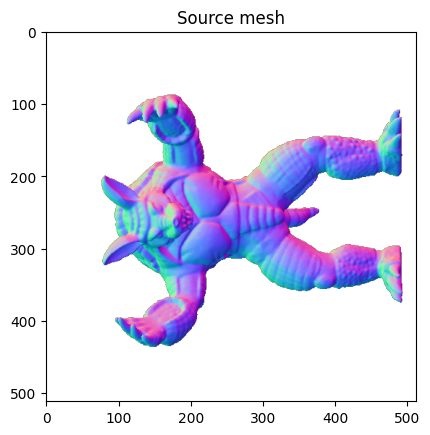

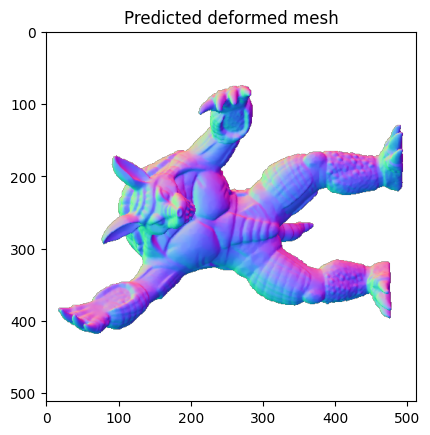

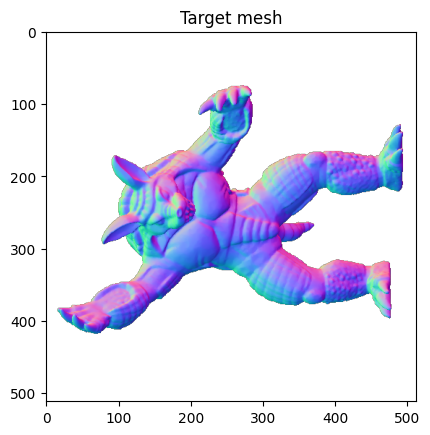

In [13]:
# visualise predicted mesh

pred_mesh_render = render_mesh(rotate_mesh90(mesh_pred), elev=90, azim=90).detach().cpu().numpy()

# visualised source and target meshes
plt.figure()
plt.title("Source mesh")
plt.imshow(source_mesh_render)
plt.savefig('./result/' + data_name + '/source.png')

plt.figure()
plt.title("Predicted deformed mesh")
plt.imshow(pred_mesh_render)
plt.savefig('./result/' + data_name + '/deformed.png')

plt.figure()
plt.title("Target mesh")
plt.imshow(target_mesh_render)
plt.savefig('./result/' + data_name + '/target.png')

In [14]:
# @title Evaluation functions (Chamfer, normals, EPE, AccS, AccR)
import torch
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance
from scipy.stats import sem
import point_cloud_utils as pcu

device = 'cuda'

def chamfer_eval(x, y, xn, yn, verbose=False):
    """
    Compute the chamfer distance and cosine normals between two point sets.

    Args:
        x (torch.Tensor): The first set of points (B x N x 3).
        y (torch.Tensor): The second set of points (B x M x 3).
        xn (torch.Tensor): The normals of the first set of points (B x N x 3).
        yn (torch.Tensor): The normals of the second set of points (B x M x 3).
        verbose (bool): If True, print the computed chamfer distances and cosine normals.

    Returns:
        torch.Tensor: The chamfer distance between x and y (B).
        torch.Tensor: The cosine normals between xn and yn (B).
    """
    l2_chamfer, l2_normals = chamfer_distance(x, y, x_normals=xn, y_normals=yn, norm=2)
    l2_chamfer, l2_normals = (10**4) * l2_chamfer, l2_normals

    if verbose:
        print("Chamfer L2 (x 10^-4): %f, Chamfer Cosine Normals: %f" %
              (float(l2_chamfer), float(l2_normals)))

    return l2_chamfer, l2_normals

def eval_surface_reconstruction_mesh(pred_mesh_path, gt_mesh_path, n_samples=10**6, device='cuda'):
    """
    Evaluate the surface reconstruction performance for two meshes.

    Args:
        pred_mesh_path (str): The file path to the predicted mesh.
        gt_mesh_path (str): The file path to the ground truth mesh.
        n_samples (int): The number of points to sample from each mesh. Defaults to 10^6.
        device (str): The device to perform computations on. Defaults to 'cuda'.

    Returns:
        torch.Tensor: The chamfer distance between predicted and ground truth meshes.
        torch.Tensor: The cosine normals between predicted and ground truth meshes.
    """
    pred_mesh = IO().load_mesh(pred_mesh_path, device=device)
    gt_mesh = IO().load_mesh(gt_mesh_path, device=device)

    gt_points, gt_normals = sample_points_from_meshes(gt_mesh, return_normals=True, num_samples=n_samples)
    pred_points, pred_normals = sample_points_from_meshes(pred_mesh, return_normals=True, num_samples=n_samples)

    l2_chamfer, l2_normals = chamfer_eval(gt_points, pred_points, gt_normals, pred_normals, verbose=True)

    return l2_chamfer, l2_normals

# the code taken from: https://github.com/rabbityl/DeformationPyramid
def scene_flow_metrics(pred, labels, strict=0.025, relax = 0.05):

    l2_norm = torch.sqrt(torch.sum((pred - labels) ** 2, 1)).cpu()  # Absolute distance error.
    labels_norm = torch.sqrt(torch.sum(labels * labels, 1)).cpu()
    relative_err = l2_norm / (labels_norm + 1e-20)

    EPE3D = torch.mean(l2_norm).item()  # Mean absolute distance error

    # NOTE: AccS
    error_lt_5 = torch.BoolTensor((l2_norm < strict))
    relative_err_lt_5 = torch.BoolTensor((relative_err < strict))
    AccS = torch.mean((error_lt_5 | relative_err_lt_5).float()).item()

    # NOTE: AccR
    error_lt_10 = torch.BoolTensor((l2_norm < relax))
    relative_err_lt_10 = torch.BoolTensor((relative_err < relax))
    AccR = torch.mean((error_lt_10 | relative_err_lt_10).float()).item()

    # NOTE: outliers
    relative_err_lt_30 = torch.BoolTensor(relative_err > 0.3)
    outlier = torch.mean(relative_err_lt_30.float()).item()

    return EPE3D, AccS*100, AccR*100 #, outlier*100


def eval_scene_flow(pred_mesh_path, gt_mesh_path, strict=0.025, relax = 0.05):

    vpred = torch.Tensor(pcu.load_mesh_v(pred_mesh_path))
    vgt = torch.Tensor(pcu.load_mesh_v(gt_mesh_path))

    epe, accs, accr =  scene_flow_metrics(vpred, vgt)

    return epe, accs, accr

In [15]:
# Evaluate registration error: endpoint error, strict accuracy, relaxed accuracy
# the metrics are taken from "Neural Deformation Pyramid" (https://arxiv.org/abs/2205.12796)

vtrg = target_mesh.verts_packed()
epe_aiap, accs_aiap, accr_aiap = scene_flow_metrics(vpred, vtrg)

# Chamfer distance, Chamfer normal consistency
cd_aiap, cdn_aiap = eval_surface_reconstruction_mesh('/home/bronyale/code/DPF/result/' + data_name + '/source_deformed_aiap.obj',
                                                     '/home/bronyale/code/DPF/data/' + data_name + '/target.obj')

print("Surface Deformation Results (AIAP regularisation, no keypoint supervision)")
print("EPE: %f, Acc_R: %f: Acc_S: %f Chamfer distance: %f, Chamfer normals: %f" %
      (epe_aiap, accs_aiap, accr_aiap, cd_aiap, cdn_aiap))

/home/bronyale/anaconda3/envs/DPF/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/home/bronyale/anaconda3/envs/DPF/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/bronyale/code/DPF/data/monster/1.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


Chamfer L2 (x 10^-4): 0.040383, Chamfer Cosine Normals: 0.023354
Surface Deformation Results (AIAP regularisation, no keypoint supervision)
EPE: 0.002362, Acc_R: 100.000000: Acc_S: 100.000000 Chamfer distance: 0.040383, Chamfer normals: 0.023354


In [24]:
# We can also easily interpolate between source and target mesh

t = 0.5 # t in [0, 1]
vpred_inter = vsrc + t*model(vsrc).detach().clone()
mesh_inter = Meshes(vpred_inter.unsqueeze(0), source_mesh.faces_packed().unsqueeze(0))
mesh_inter = get_normals_as_textures(mesh_inter)
IO().save_mesh(mesh_inter, 'result/' + data_name + '/source_interpolated.obj')
pred_mesh_render = render_mesh(rotate_mesh90(mesh_inter), elev=90, azim=90).detach().cpu().numpy()
plt.figure()
plt.title("Inerpolated (t=%0.1f)" % t)
plt.imshow(pred_mesh_render)
plt.savefig('result/' + data_name + '/interpolated.png')

t = 1.2 # t in [0, 1]
vpred_inter = vsrc + t*model(vsrc).detach().clone()
mesh_inter = Meshes(vpred_inter.unsqueeze(0), source_mesh.faces_packed().unsqueeze(0))
mesh_inter = get_normals_as_textures(mesh_inter)
IO().save_mesh(mesh_inter, 'result/' + data_name + '/source_prediction.obj')
pred_mesh_render = render_mesh(rotate_mesh90(mesh_inter), elev=90, azim=90).detach().cpu().numpy()
plt.figure()
plt.title("Inerpolated (t=%0.1f)" % t)
plt.imshow(pred_mesh_render)
plt.savefig('result/' + data_name + '/prediction_1.png')

t = 1.4 # t in [0, 1]
vpred_inter = vsrc + t*model(vsrc).detach().clone()
mesh_inter = Meshes(vpred_inter.unsqueeze(0), source_mesh.faces_packed().unsqueeze(0))
mesh_inter = get_normals_as_textures(mesh_inter)
IO().save_mesh(mesh_inter, 'result/' + data_name + '/source_prediction.obj')
pred_mesh_render = render_mesh(rotate_mesh90(mesh_inter), elev=90, azim=90).detach().cpu().numpy()
plt.figure()
plt.title("Inerpolated (t=%0.1f)" % t)
plt.imshow(pred_mesh_render)
plt.savefig('result/' + data_name + '/prediction_2.png')

AttributeError: 'numpy.ndarray' object has no attribute 'verts_normals_packed'

In [29]:
# now let's repeat the deformation learning, but without the AIAP loss (baseline model)

# define our deformation function
model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# start training, withoit AIAP loss
deform_cloud(model,
             xsrc=xsrc, xtrg=xtrg,
             init_lr=1.0e-4,
             n_steps=2000,
             use_chamfer=True,
             use_guidance=False,
             use_aiap=False,
             use_aiap_inter=False,
             device=DEVICE)

00000 total loss: 115.937798, guidl: 0.000000, chaml. :115.937798, AIAP: 0.000000
00100 total loss: 4.240878, guidl: 0.000000, chaml. :4.240878, AIAP: 0.000000
00200 total loss: 2.196177, guidl: 0.000000, chaml. :2.196177, AIAP: 0.000000
00300 total loss: 2.166302, guidl: 0.000000, chaml. :2.166302, AIAP: 0.000000
00400 total loss: 2.154348, guidl: 0.000000, chaml. :2.154348, AIAP: 0.000000
00500 total loss: 2.146223, guidl: 0.000000, chaml. :2.146223, AIAP: 0.000000
00600 total loss: 2.155040, guidl: 0.000000, chaml. :2.155040, AIAP: 0.000000
00700 total loss: 2.150089, guidl: 0.000000, chaml. :2.150089, AIAP: 0.000000
00800 total loss: 2.115749, guidl: 0.000000, chaml. :2.115749, AIAP: 0.000000
00900 total loss: 2.109699, guidl: 0.000000, chaml. :2.109699, AIAP: 0.000000
01000 total loss: 2.104799, guidl: 0.000000, chaml. :2.104799, AIAP: 0.000000
01100 total loss: 2.105779, guidl: 0.000000, chaml. :2.105779, AIAP: 0.000000
01200 total loss: 2.107720, guidl: 0.000000, chaml. :2.10772

In [30]:
# @title Evaluate the baseline model
# predict new vertex locations with our learned deformation
from pytorch3d.io import IO

model.eval()

vpred = vsrc + model(vsrc).detach().clone()

mesh_pred = deform_mesh(source_mesh, model)
mesh_pred = get_normals_as_textures(mesh_pred)

IO().save_mesh(mesh_pred, 'source_deformed_baseline.obj')

# evaluate our baseline model

epe_base, accs_base, accr_base = scene_flow_metrics(vpred, vtrg)

cd_base, cdn_base = eval_surface_reconstruction_mesh('/content/source_deformed_baseline.obj',
                                                     '/content/target.obj')

FileNotFoundError: [Errno 2] No such file or directory: '/content/source_deformed_baseline.obj'

In [ ]:
# using AIAP influences the quality of the registration: lower endpoint error, higher accuracy
print("Surface Deformation Results (NO AIAP regularisation, no keypoint supervision)")
print("EPE: %f, Acc_R: %f: Acc_S: %f Chamfer distance: %f, Chamfer normals: %f" %
      (epe_base, accs_base, accr_base, cd_base, cdn_base))

print("Surface Deformation Results (AIAP regularisation, no keypoint supervision)")
print("EPE: %f, Acc_R: %f: Acc_S: %f Chamfer distance: %f, Chamfer normals: %f" %
      (epe_aiap, accs_aiap, accr_aiap, cd_aiap, cdn_aiap))

Surface Deformation Results (NO AIAP regularisation, no keypoint supervision)
EPE: 0.016963, Acc_R: 74.366176: Acc_S: 95.801431 Chamfer distance: 0.040982, Chamfer normals: 0.020077
Surface Deformation Results (AIAP regularisation, no keypoint supervision)
EPE: 0.012680, Acc_R: 86.064321: Acc_S: 99.068403 Chamfer distance: 0.062177, Chamfer normals: 0.022992


In [ ]:
# now let's use the provided Lepard keypoint correspondences for supervision

ksrc = torch.Tensor(pcu.load_mesh_v('/content/source_lepard.obj')).to(DEVICE)
ktrg = torch.Tensor(pcu.load_mesh_v('/content/target_lepard.obj')).to(DEVICE)

# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# we set a lower AIAP weight, since the model is well-regularised by the keypoints
AIAP_WEIGHT = 1.0e1

# start training, withoit AIAP loss
deform_cloud(model,
             xsrc=xsrc, xtrg=xtrg,
             vsrc=ksrc, vtrg=ktrg,
             init_lr=1.0e-4,
             n_steps=2000,
             aiap_weight=AIAP_WEIGHT,
             guided_weight=1.0e2,
             use_chamfer=True,
             use_guidance=True,
             use_aiap=True,
             use_aiap_inter=False,
             device=DEVICE)

00000 total loss: 96.572868, guidl: 5.586617, chaml. :90.967606, AIAP: 0.018644
00100 total loss: 5.415023, guidl: 1.433032, chaml. :3.961540, AIAP: 0.020452
00200 total loss: 2.929398, guidl: 0.744931, chaml. :2.166616, AIAP: 0.017852
00300 total loss: 2.876488, guidl: 0.693274, chaml. :2.164499, AIAP: 0.018715
00400 total loss: 2.845502, guidl: 0.662836, chaml. :2.163022, AIAP: 0.019644
00500 total loss: 2.829068, guidl: 0.644464, chaml. :2.164421, AIAP: 0.020184
00600 total loss: 2.827164, guidl: 0.632404, chaml. :2.174084, AIAP: 0.020675
00700 total loss: 2.811443, guidl: 0.617638, chaml. :2.172625, AIAP: 0.021180
00800 total loss: 2.792684, guidl: 0.602566, chaml. :2.168384, AIAP: 0.021734
00900 total loss: 2.789571, guidl: 0.594434, chaml. :2.172939, AIAP: 0.022198
01000 total loss: 2.777369, guidl: 0.581183, chaml. :2.173483, AIAP: 0.022702
01100 total loss: 2.766576, guidl: 0.570533, chaml. :2.172834, AIAP: 0.023210
01200 total loss: 2.758860, guidl: 0.556487, chaml. :2.178641,

In [ ]:
# @title Evaluate the Lepard-supervised model

from pytorch3d.io import IO

model.eval()

vpred = vsrc + model(vsrc).detach().clone()

mesh_pred = deform_mesh(source_mesh, model)
mesh_pred = get_normals_as_textures(mesh_pred)

IO().save_mesh(mesh_pred, 'source_deformed_supervised.obj')

epe_supervised, accs_supervised, accr_supervised = scene_flow_metrics(vpred, vtrg)

cd_supervised, cdn_supervised = eval_surface_reconstruction_mesh('/content/source_deformed_supervised.obj',
                                                                 '/content/target.obj')

Chamfer L2 (x 10^-4): 0.081934, Chamfer Cosine Normals: 0.028178


In [ ]:
# Now let's compare the supervised model with the AIAP-only and the baseline
# Lepard keypoint supervision boosts the registration accuracy compared to the baseline model.

print("****Surface Deformation Results (NO AIAP regularisation, NO keypoint supervision)****")
print("EPE: %f, Acc_R: %f: Acc_S: %f Chamfer distance: %f, Chamfer normals: %f" %
      (epe_base, accs_base, accr_base, cd_base, cdn_base))

print("****Surface Deformation Results (WITH AIAP regularisation, NO keypoint supervision)****")
print("EPE: %f, Acc_R: %f: Acc_S: %f Chamfer distance: %f, Chamfer normals: %f" %
      (epe_aiap, accs_aiap, accr_aiap, cd_aiap, cdn_aiap))

print("****Surface Deformation Results (WITH AIAP regularisation, WITH keypoint supervision)****")
print("EPE: %f, Acc_R: %f: Acc_S: %f Chamfer distance: %f, Chamfer normals: %f" %
      (epe_supervised, accs_supervised, accr_supervised, cd_supervised, cdn_supervised))

****Surface Deformation Results (NO AIAP regularisation, NO keypoint supervision)****
EPE: 0.016963, Acc_R: 74.366176: Acc_S: 95.801431 Chamfer distance: 0.040982, Chamfer normals: 0.020077
****Surface Deformation Results (WITH AIAP regularisation, NO keypoint supervision)****
EPE: 0.012680, Acc_R: 86.064321: Acc_S: 99.068403 Chamfer distance: 0.062177, Chamfer normals: 0.022992
****Surface Deformation Results (WITH AIAP regularisation, WITH keypoint supervision)****
EPE: 0.013251, Acc_R: 90.288413: Acc_S: 99.753273 Chamfer distance: 0.081934, Chamfer normals: 0.028178
